## High-dimensional Linear Regression

In [38]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pdb

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline
display.set_matplotlib_formats('svg')

In [2]:
feature_dim, n_sample = 200, 40
feature = torch.randn(n_sample, feature_dim)
w_true = torch.Tensor([0.01]*200)
# help(np.random.normal)
epsilon = torch.from_numpy(np.random.normal(scale=0.01, size=n_sample))

y = torch.matmul(feature, w_true) + epsilon
epsilon, torch.matmul(feature, w_true), y

(tensor([-2.4761e-03,  7.0664e-03,  3.4864e-05,  1.0265e-03,  1.0008e-02,
         -8.9577e-03, -6.0722e-03, -7.5298e-05,  1.0539e-03,  2.0959e-02,
         -1.1231e-02, -1.7279e-02,  2.1401e-02, -1.2149e-02,  1.5178e-02,
          6.2224e-03, -3.4761e-03, -2.0463e-02, -1.0588e-02, -1.4978e-02,
         -1.3798e-03,  1.4598e-02,  1.5603e-03,  2.7722e-03, -6.2479e-03,
         -1.4121e-02, -3.3180e-03,  1.5788e-03,  8.2533e-03,  9.2137e-03,
          2.2273e-02,  1.3701e-02,  4.3643e-03, -1.1159e-02,  1.5763e-03,
          1.2555e-03, -6.3980e-03, -2.5961e-03, -4.7667e-03,  2.0205e-03],
        dtype=torch.float64),
 tensor([-0.1090, -0.0151,  0.1354,  0.2263,  0.0557,  0.0420,  0.1088, -0.0025,
         -0.1127,  0.0366,  0.1322, -0.0764,  0.0141,  0.1329,  0.0876, -0.1894,
         -0.0069, -0.0330, -0.1035,  0.0407, -0.3016,  0.1620, -0.2538,  0.0996,
         -0.0593, -0.1294, -0.0413, -0.0885,  0.0667, -0.1132,  0.2334, -0.0995,
         -0.0441,  0.0124, -0.2261,  0.0011,  0.0887,

In [3]:
train_feature, test_feature = feature[:20], feature[20:]
train_label, test_label = y[:20], y[20:]

In [9]:
def SynDataset(Dataset):
    def __init__(self, data):
        super(SyntheticDataset, self).__init__()
        
        self.feature, self.label = data
        
    def __getitem__(self,  idx):
        pdb.set_trace()
        return self.feature[idx], self.label[idx]
    
    def __len__(self):
        return len(self.label)

In [28]:
class PolyDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        super(PolyDataset, self).__init__()
        self.features = features
        self.labels = labels
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    def __len__(self):
        return len(self.labels)

In [10]:
class Model(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Model, self).__init__()
        self.net = nn.Linear(in_channel, out_channel, bias=True)
        
    def forward(self, data):
        return self.net(data)

In [26]:
class L2_penalty(nn.Module):
    def __init__(self):
        super(L2_penalty, self).__init__()
#         self.net = nn.Linear(in_channel, out_channel, bias=True)
        self.mse_loss = nn.MSELoss(reduction='mean')
        
    def forward(self, net, output, label):
        return self.mse_loss(output, label) + (net.net.weight**2).sum()/2

In [61]:
def evaluate_loss(net, loader, loss_func):
    net.eval()
    val_loss = []
    for idx, data in enumerate(loader):
        features, labels = data
        output = net(features)
#         pdb.set_trace()
        if isinstance(loss_func, nn.MSELoss):
            loss = loss_func(output.squeeze(), labels)
        else:
            loss = loss_func(net, output.squeeze(), labels)
        val_loss.append(loss.item())

    return np.mean(val_loss)

## 4.5.1 Implementation from Scratch

In [62]:
def train(epochs, lr, train_feature, train_label, test_feature, test_label, in_channel, loss_func):
    batch_size = 16
#     pdb.set_trace()
#     trainset = SynDataset([train_feature, train_label])
#     testset = SynDataset([test_feature, test_label])
#     train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)
    trainset = PolyDataset(train_feature, train_label)
    testset = PolyDataset(test_feature, test_label)
    train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)
    
    net = Model(in_channel, 1)
#     loss_func = L2_penalty()
    optim = torch.optim.SGD(net.parameters(), lr = lr)
    
    
    train_loss, test_loss = [], []
    for epo in range(epochs):
        epo_loss = []
        for idx, data in enumerate(train_loader):
            net.train()
            feature, label = data
#             pdb.set_trace()
            output = net(feature)
#             print(output.shape)
            optim.zero_grad()
            if isinstance(loss_func, nn.MSELoss):
                iter_loss = loss_func(output.squeeze(), label.float())
            else:
                iter_loss = loss_func(net, output.squeeze(), label.float())
            iter_loss.backward()
            optim.step()

            epo_loss.append(iter_loss.item())
            
        train_loss.append(np.mean(epo_loss))
        test_loss.append(evaluate_loss(net, test_loader, loss_func))
        
        if (epo+1) % 50 == 0:
            print(f'epoch {epo} train loss: {train_loss[epo]}, test loss: {test_loss[epo]}')

    return train_loss, test_loss, net

In [63]:
train_loss, test_loss, net = train(400, 0.01, train_feature, train_label, test_feature, test_label, feature_dim, L2_penalty())

epoch 49 train loss: 0.021838979795575142, test loss: 0.0934063774134164
epoch 99 train loss: 0.003538456396199763, test loss: 0.025107698139311636
epoch 149 train loss: 0.0010621201945468783, test loss: 0.0111133729748194
epoch 199 train loss: 0.000700213888194412, test loss: 0.010726144911908212
epoch 249 train loss: 0.0006276636850088835, test loss: 0.020095721818062105
epoch 299 train loss: 0.0006084773340262473, test loss: 0.016276507696364146
epoch 349 train loss: 0.0005986716714687645, test loss: 0.018213500292796357
epoch 399 train loss: 0.0005946273449808359, test loss: 0.0206019704293025


In [50]:
def visual(train_loss, test_loss):
    plt.plot(list(range(len(train_loss))), train_loss, label='train_loss')
    plt.plot(list(range(len(test_loss))), test_loss, label='test_loss')
    
    plt.legend()
    plt.show()

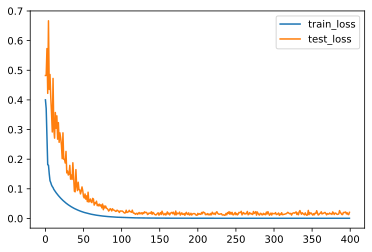

In [64]:
visual(train_loss, test_loss)

## Without weight dacay

In [69]:
train_loss, test_loss, net = train(400, 0.01, train_feature, train_label, test_feature, test_label, feature_dim, nn.MSELoss(reduction='mean'))

epoch 49 train loss: 1.4225195674177904e-11, test loss: 0.3084655620233445
epoch 99 train loss: 1.0614627259835155e-15, test loss: 0.3971113520171708
epoch 149 train loss: 4.85322773722402e-16, test loss: 0.2848737323166768
epoch 199 train loss: 2.292291383836423e-16, test loss: 0.28572776466839733
epoch 249 train loss: 3.000004351926336e-16, test loss: 0.22142466622154527
epoch 299 train loss: 5.280352571206473e-16, test loss: 0.2547568322067858
epoch 349 train loss: 1.4561004583069775e-16, test loss: 0.2865268622584125
epoch 399 train loss: 1.9312520603987499e-16, test loss: 0.2227232637599349


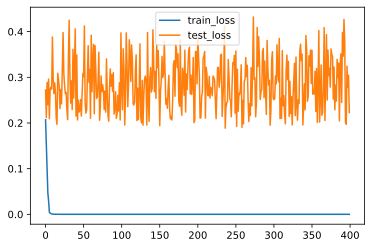

In [70]:
visual(train_loss, test_loss)

## 4.5.2 Concise Implementation

In [71]:
def train(epochs, lr, train_feature, train_label, test_feature, test_label, in_channel, wd):
    batch_size = 16

    trainset = PolyDataset(train_feature, train_label)
    testset = PolyDataset(test_feature, test_label)
    train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)
    
    net = Model(in_channel, 1)
    loss_func = nn.MSELoss(reduction='mean')
    # By default, Pytorch decays both weights and biases simultaneously. 
    # The weight parameter has been decayed with its weight_decay set as wd
    # The weight_decay for bias is by default zero (no decay)
    optim = torch.optim.SGD([{'params': net.net.weight, 'weight_decay':wd}, {'params': net.net.bias}], lr = lr)
    
    
    train_loss, test_loss = [], []
    for epo in range(epochs):
        epo_loss = []
        for idx, data in enumerate(train_loader):
            net.train()
            feature, label = data
            output = net(feature)
#             print(output.shape)
            optim.zero_grad()
            if isinstance(loss_func, nn.MSELoss):
                iter_loss = loss_func(output.squeeze(), label.float())
            else:
                iter_loss = loss_func(net, output.squeeze(), label.float())
            iter_loss.backward()
            optim.step()

            epo_loss.append(iter_loss.item())
            
        train_loss.append(np.mean(epo_loss))
        test_loss.append(evaluate_loss(net, test_loader, loss_func))
        
        if (epo+1) % 50 == 0:
            print(f'epoch {epo} train loss: {train_loss[epo]}, test loss: {test_loss[epo]}')

    return train_loss, test_loss, net

### without weight decay

In [72]:
train_loss, test_loss, net = train(400, 0.01, train_feature, train_label, test_feature, test_label, feature_dim, 0)

epoch 49 train loss: 4.3243236275873967e-13, test loss: 0.28403453863813694
epoch 99 train loss: 1.1722139779029098e-15, test loss: 0.3818747875751992
epoch 149 train loss: 3.994759845181786e-16, test loss: 0.4014293414507184
epoch 199 train loss: 3.8559819671036416e-16, test loss: 0.38814852488806617
epoch 249 train loss: 8.286032043879413e-16, test loss: 0.3403722667580602
epoch 299 train loss: 1.9361309701749346e-16, test loss: 0.5063262084291422
epoch 349 train loss: 7.966344868926695e-17, test loss: 0.4566715727010162
epoch 399 train loss: 6.272787194186447e-17, test loss: 0.3354476473637651


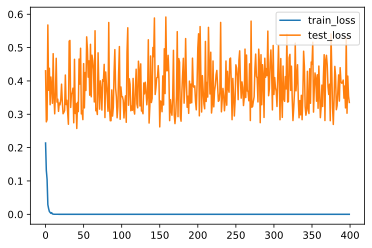

In [73]:
visual(train_loss, test_loss)

### with weight dacay

In [74]:
train_loss, test_loss, net = train(400, 0.01, train_feature, train_label, test_feature, test_label, feature_dim, 3)

epoch 49 train loss: 0.0004188778402749449, test loss: 0.018435647411050384
epoch 99 train loss: 0.0003293803601991385, test loss: 0.018839649762284846
epoch 149 train loss: 0.00020581784337991849, test loss: 0.013586270208873244
epoch 199 train loss: 0.00028014605049975216, test loss: 0.023607128519353912
epoch 249 train loss: 0.00019171889653080143, test loss: 0.014296204829648041
epoch 299 train loss: 0.0001980801644094754, test loss: 0.01472211623299926
epoch 349 train loss: 0.00018471279690857045, test loss: 0.014148801188759198
epoch 399 train loss: 0.0003039066505152732, test loss: 0.015553606693059045


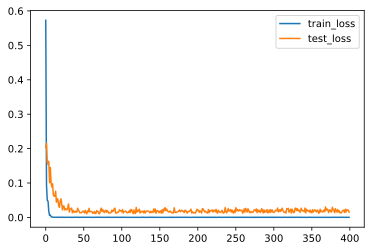

In [75]:
visual(train_loss, test_loss)